In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# load Data
diabetic_data = "../data/diabetic_data.csv"  
IDS_mapping = '../data/IDS_mapping.csv'
df = pd.read_csv(diabetic_data)

# --- Initial Cleaning ---
drop_cols = ['encounter_id', 'patient_nbr', 'weight', 'payer_code', 'medical_specialty']
df = df.drop(columns=drop_cols)

# replace '?' with 'Unknown'
df = df.replace('?', 'Unknown')

# remove patients discharged to hospice or who died
death_hospice_ids = [11, 19, 20, 21]
df = df[~df['discharge_disposition_id'].isin(death_hospice_ids)]

# keep only valid readmission labels and create binary target
df = df[df['readmitted'].isin(['NO', '<30', '>30'])].copy()
df['readmit_binary'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

# drop gender "Unknown/Invalid"
df = df[df['gender'] != 'Unknown/Invalid']

/var/folders/dy/qnsxspzs7cn6ng23pqmmckpm0000gn/T/ipykernel_82333/228324470.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='readmit_binary', data=df, palette='Blues', ax=axes[0, 0])
/var/folders/dy/qnsxspzs7cn6ng23pqmmckpm0000gn/T/ipykernel_82333/228324470.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='race', data=df, order=df['race'].value_counts().index, palette='viridis', ax=axes[0, 1])
/var/folders/dy/qnsxspzs7cn6ng23pqmmckpm0000gn/T/ipykernel_82333/228324470.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='ge

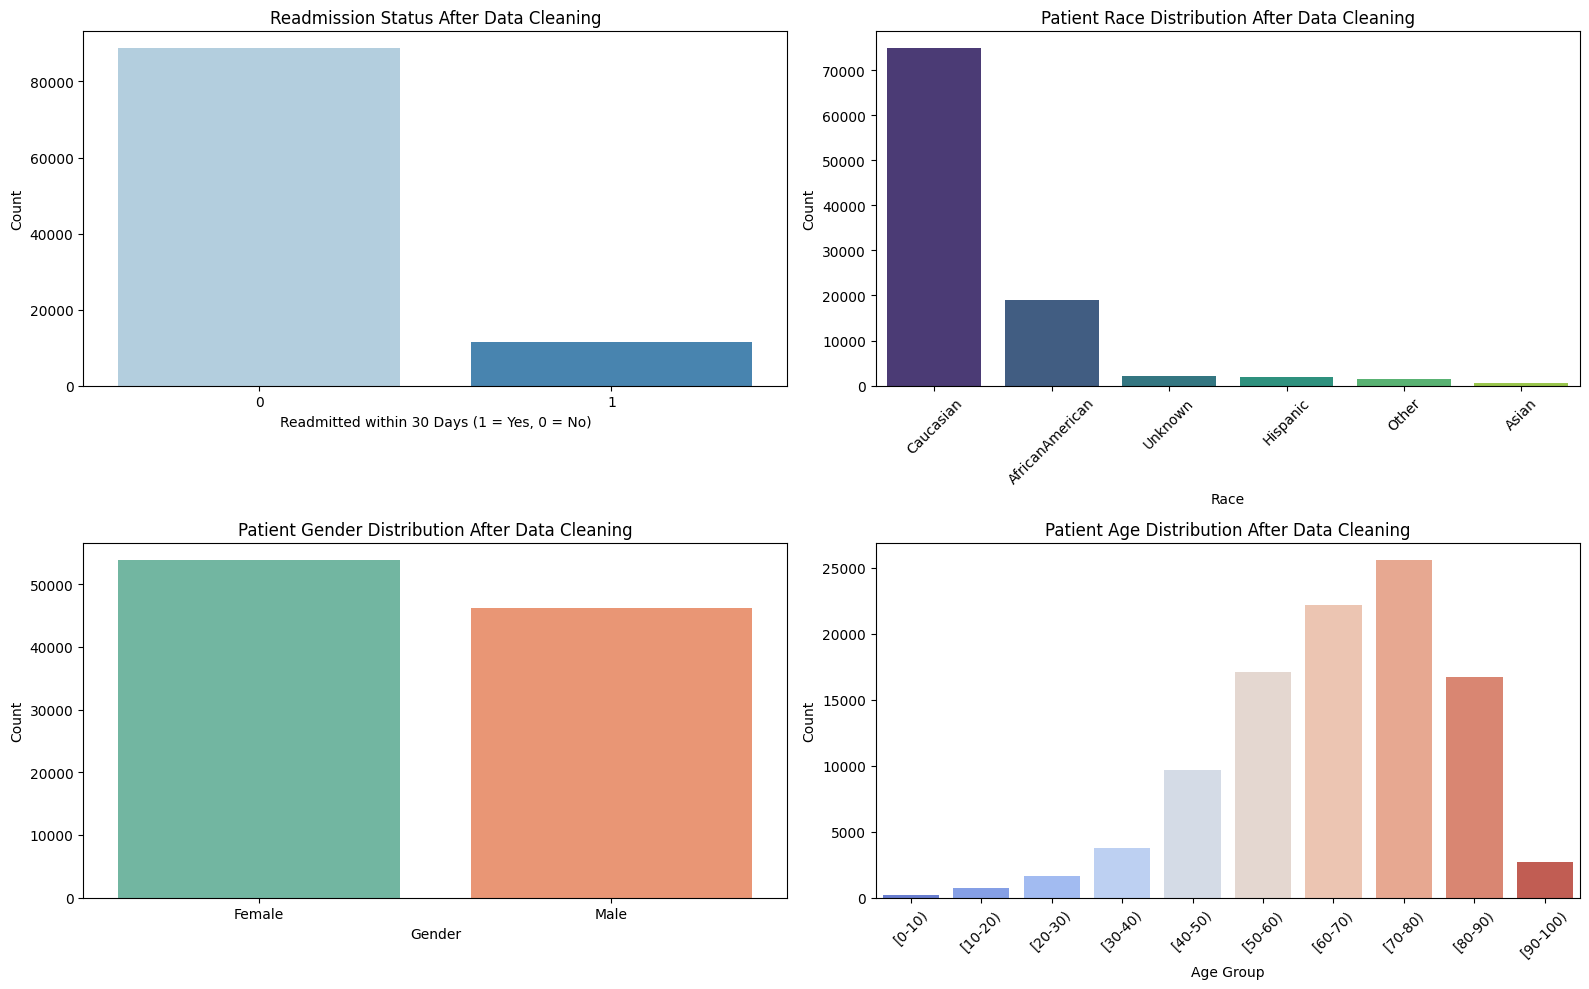

In [2]:
# --- Visualization ---
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# readmission status distribution
sns.countplot(x='readmit_binary', data=df, palette='Blues', ax=axes[0, 0])
axes[0, 0].set_title('Readmission Status After Data Cleaning')
axes[0, 0].set_xlabel('Readmitted within 30 Days (1 = Yes, 0 = No)')
axes[0, 0].set_ylabel('Count')

# race distribution
sns.countplot(x='race', data=df, order=df['race'].value_counts().index, palette='viridis', ax=axes[0, 1])
axes[0, 1].set_title('Patient Race Distribution After Data Cleaning')
axes[0, 1].set_xlabel('Race')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=45)

# gender distribution
sns.countplot(x='gender', data=df, palette='Set2', ax=axes[1, 0])
axes[1, 0].set_title('Patient Gender Distribution After Data Cleaning')
axes[1, 0].set_xlabel('Gender')
axes[1, 0].set_ylabel('Count')

# age distribution
sns.countplot(x='age', data=df, order=sorted(df['age'].unique()), palette='coolwarm', ax=axes[1, 1])
axes[1, 1].set_title('Patient Age Distribution After Data Cleaning')
axes[1, 1].set_xlabel('Age Group')
axes[1, 1].set_ylabel('Count')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# --- feature set ---
categorical_features = [
    'race', 'gender', 'age', 'admission_type_id',
    'discharge_disposition_id', 'admission_source_id',
    'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed'
] + [col for col in df.columns if col.startswith((
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
    'rosiglitazone', 'acarbose', 'miglitol', 'tolazamide', 'examide',
    'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone'
))]

numerical_features = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
    'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses'
]

# preprocessing pipelines
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical_features),
    ('num', numerical_transformer, numerical_features)
])

# split data
X = df[categorical_features + numerical_features]
y = df['readmit_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

Processed training shape: (80088, 155)
Processed test shape: (20023, 155)


In [4]:
# save the cleaned data
df.to_csv('../data/data_cleaned.csv', index=False)
print("Cleaned data saved to 'data_cleaned.csv'.")

Cleaned data saved to 'data_cleaned.csv'.


### Logistic Regression Model

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import yaml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report, confusion_matrix

df = pd.read_csv("../data/data_cleaned.csv")

In [12]:
# --- Logistic Regression Model ---
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

param_grid_logreg = {
    'classifier__C': [0.01, 0.1, 1, 10]
}

grid_logreg = GridSearchCV(
    logreg_pipeline, param_grid_logreg,
    scoring='roc_auc', cv=5, n_jobs=-1
)
grid_logreg.fit(X_train, y_train)

# best logreg model
best_logreg = grid_logreg.best_estimator_


### XGBoost Model

In [13]:
# --- XGBoost Model Training ---
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

param_grid_xgb = {
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__max_depth': [3, 5, 7],
    'classifier__n_estimators': [100, 200]
}

grid_xgb = GridSearchCV(
    xgb_pipeline, param_grid_xgb,
    scoring='roc_auc', cv=5, n_jobs=-1
)
grid_xgb.fit(X_train, y_train)

# best xgboost model
best_xgb = grid_xgb.best_estimator_

/opt/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:52:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:52:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:52:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:52:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iterati

### Model Evaluation

In [16]:
# helper functions
def compute_bootstrap_auc(y_true, y_pred, n_bootstraps=1000, seed=42):
    np.random.seed(seed)
    bootstrapped_scores = []
    for i in range(n_bootstraps):
        indices = np.random.randint(0, len(y_true), len(y_true))
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    lower = sorted_scores[int(0.025 * len(sorted_scores))]
    upper = sorted_scores[int(0.975 * len(sorted_scores))]
    return lower, upper

def compute_sensitivity_specificity(y_true, y_pred_binary):
    cm = confusion_matrix(y_true, y_pred_binary)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    return sensitivity, specificity

# evaluate logistic regression
y_pred_logreg = best_logreg.predict_proba(X_test)[:, 1]
y_pred_logreg_binary = (y_pred_logreg >= 0.5).astype(int)

auc_logreg = roc_auc_score(y_test, y_pred_logreg)
auc_logreg_ci = compute_bootstrap_auc(y_test.values, y_pred_logreg)

print(f"Logistic Regression AUC: {auc_logreg:.4f}")
print(f"95% CI for Logistic Regression AUC: {auc_logreg_ci}")

print("Classification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_logreg_binary))

sens_logreg, spec_logreg = compute_sensitivity_specificity(y_test, y_pred_logreg_binary)
print(f"Logistic Regression Sensitivity: {sens_logreg:.4f}")
print(f"Logistic Regression Specificity: {spec_logreg:.4f}")

# evaluate XGBoost
y_pred_xgb = best_xgb.predict_proba(X_test)[:, 1]
y_pred_xgb_binary = (y_pred_xgb >= 0.5).astype(int)

auc_xgb = roc_auc_score(y_test, y_pred_xgb)
auc_xgb_ci = compute_bootstrap_auc(y_test.values, y_pred_xgb)

print(f"\nXGBoost AUC: {auc_xgb:.4f}")
print(f"95% CI for XGBoost AUC: {auc_xgb_ci}")

print("Classification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb_binary))

sens_xgb, spec_xgb = compute_sensitivity_specificity(y_test, y_pred_xgb_binary)
print(f"XGBoost Sensitivity: {sens_xgb:.4f}")
print(f"XGBoost Specificity: {spec_xgb:.4f}")

# save best models
with open('../models/best_logistic_regression.pkl', 'wb') as f:
    pickle.dump(best_logreg, f)

with open('../models/best_xgboost.pkl', 'wb') as f:
    pickle.dump(best_xgb, f)

print("Best models saved as pickle files.")

# save training configs to yaml
config_logreg = {
    'model': 'LogisticRegression',
    'best_params': grid_logreg.best_params_,
    'auc': auc_logreg,
    'auc_ci': auc_logreg_ci,
    'sensitivity': sens_logreg,
    'specificity': spec_logreg
}

config_xgb = {
    'model': 'XGBoost',
    'best_params': grid_xgb.best_params_,
    'auc': auc_xgb,
    'auc_ci': auc_xgb_ci,
    'sensitivity': sens_xgb,
    'specificity': spec_xgb
}

full_config = {
    'logistic_regression': config_logreg,
    'xgboost': config_xgb
}

with open('../models/training_configs.yaml', 'w') as f:
    yaml.dump(full_config, f)

print("Training configurations saved to '../models/training_configs.yaml'.")

Logistic Regression AUC: 0.6622
95% CI for Logistic Regression AUC: (np.float64(0.6501355362433671), np.float64(0.6739158003149185))
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.92      0.70      0.79     17752
           1       0.18      0.53      0.27      2271

    accuracy                           0.68     20023
   macro avg       0.55      0.62      0.53     20023
weighted avg       0.84      0.68      0.74     20023

Logistic Regression Sensitivity: 0.5341
Logistic Regression Specificity: 0.6988

XGBoost AUC: 0.6677
95% CI for XGBoost AUC: (np.float64(0.6564044244806434), np.float64(0.6788815726259415))
Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     17752
           1       0.53      0.01      0.02      2271

    accuracy                           0.89     20023
   macro avg       0.71      0.51      0.48     20023
